In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import time
from sklearn import neighbors
from vast.voidfinder._voidfinder_cython_find_next import MaskChecker
import pickle

/Users/lorenzomendoza/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**If observing real galaxy survey, take input of related pickle file**

In [2]:
mask_file_name = "/Users/lorenzomendoza/Desktop/Research/Function/NSA_main_mask.pickle"

In [3]:
temp_infile = open(mask_file_name, "rb")
mask, mask_resolution = pickle.load(temp_infile)
temp_infile.close()

In [4]:
file_name1 = "/Users/lorenzomendoza/Desktop/Research/Function/VoidFinder-nsa_v1_0_1_main_comoving_holes.txt"
data_table_V1 = Table.read(file_name1, format = "ascii.commented_header")

file_name2 = "/Users/lorenzomendoza/Desktop/Research/Function/VoidFinder-nsa_v1_0_1_main_comoving_maximal.txt"
data_table_V1max = Table.read(file_name2, format = "ascii.commented_header")

file_name3 = "/Users/lorenzomendoza/Desktop/Research/Function/VoidFinder-nsa_v1_0_1_main_comoving_holes.txt"
data_table_V2 = Table.read(file_name3, format = "ascii.commented_header")

file_name4 = "/Users/lorenzomendoza/Desktop/Research/Function/VoidFinder-nsa_v1_0_1_main_comoving_maximal.txt"
data_table_V2max = Table.read(file_name4, format = "ascii.commented_header")

In [5]:
data_table_V1

x,y,z,radius,flag
float64,float64,float64,float64,int64
-169.04128243715337,162.88440502982797,209.44050219289232,22.44170178630279,0
-169.26761027071854,163.62748327405512,210.22432043434242,22.362424874424708,0
-135.96850622649848,52.52855483415867,271.5381732396927,22.335325862976326,1
-169.63420742273843,162.11260003147126,207.99204934861183,22.291403263324842,0
-136.76450359851552,52.44281052688648,271.93271775286763,22.233524855787394,1
-137.14896050565565,52.77779538408528,272.0749857385887,22.091889832714706,1
-167.67959697503076,95.8127023538461,251.7356282803856,21.957089470162288,2
-137.5591701493543,52.873770575201654,272.10342383795216,21.889620898166555,1
-168.3084712049626,162.0778818822857,211.2075591544203,21.869523846899938,0


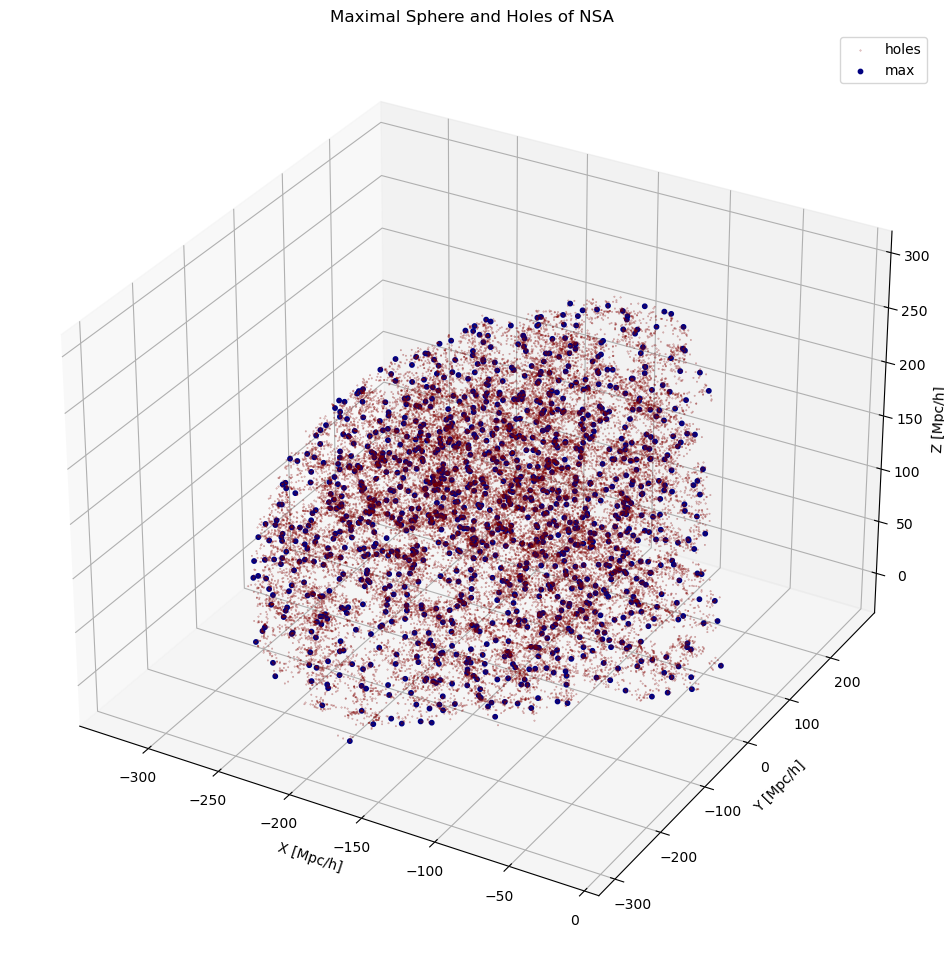

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(data_table_V1['x'],data_table_V1['y'], data_table_V1['z'],
           color = 'maroon', s=0.1, alpha=0.5,
           label='holes')
ax.scatter(data_table_V1max['x'],data_table_V1max['y'], data_table_V1max['z'],
           color = 'navy', s=10, alpha=1.0,
           label='max')
ax.set(xlabel='X [Mpc/h]', ylabel='Y [Mpc/h]', zlabel='Z [Mpc/h]')

ax.legend(loc='upper right', fontsize=10)

plt.title("Maximal Sphere and Holes of NSA");

In [7]:
def calc_volume_boundaries(void_cat_A, void_cat_B):
    """Compute the boundaries of the minimal rectangular volume (parallelpiped)
    that completely contains two void catalogs.
    
    Parameters
    ----------
    void_cat_A : astropy.Table
        Table of void data from first catalog.
    void_cat_B : astropy.Table
        Table of void data from second catalog.
        
    Returns
    -------
    x_min : float
    x_max : float
    y_min : float
    y_max : float
    z_min : float
    z_max : float
    """
    x_min = np.minimum(np.min(void_cat_A['x']), np.min(void_cat_B['x']))
    x_max = np.maximum(np.max(void_cat_A['x']), np.max(void_cat_B['x']))
    
    y_min = np.minimum(np.min(void_cat_A['y']), np.min(void_cat_B['y']))
    y_max = np.maximum(np.max(void_cat_A['y']), np.max(void_cat_B['y']))

    z_min = np.minimum(np.min(void_cat_A['z']), np.min(void_cat_B['z']))
    z_max = np.maximum(np.max(void_cat_A['z']), np.max(void_cat_B['z']))

    return x_min, x_max, y_min, y_max, z_min, z_max

def generate_grid_points(x_min, x_max, y_min, y_max, z_min, z_max):
    """Creates a dense rectangular grid of points in 3D for the void volume calculation.
    
    Returns
    -------
    xyz : list
        2D list of points in 3D space.
    """
    
    x_range = np.arange(x_min, x_max) # default spacing: 1 Megaparsec
    y_range = np.arange(y_min, y_max)
    z_range = np.arange(z_min, z_max)

    # Creating a meshgrid from the ranges to 
    X,Y,Z = np.meshgrid(x_range,y_range,z_range)

    x_points = np.ravel(X)
    y_points = np.ravel(Y)
    z_points = np.ravel(Z)
    
    point_coords = np.array([x_points, y_points, z_points])
    
    return point_coords

In [8]:
#This line creates the boundaries (like the whole min and max)
xmin, xmax, ymin, ymax, zmin, zmax = calc_volume_boundaries(data_table_V1, data_table_V2)

#This line makes creates the points in between 
pts = generate_grid_points(xmin, xmax, ymin, ymax, zmin, zmax)

b = pts.shape
print(b)

(3, 55431048)


In [9]:
print(xmin)
print(ymin)
print(zmin)

print(xmax)
print(ymax)
print(zmax)



-326.7976471961093
-293.6551784060517
-15.611520250912289
-13.35262695591469
270.1737049088635
296.6300100288663


In [10]:
pts
pts.shape

(3, 55431048)

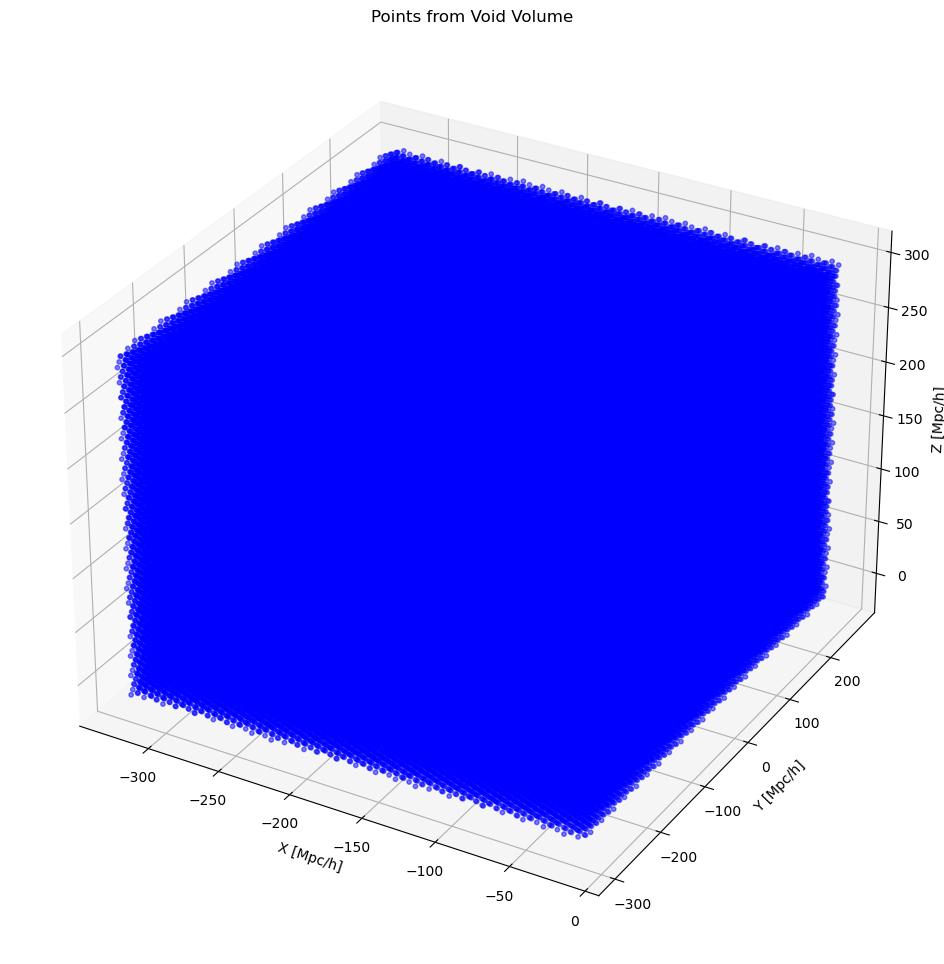

In [11]:
""" This will take the 3D array of pts and plot along each axis
    (x, y, z)
"""
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(pts[0,::100],pts[1,::100], pts[2,::100],
           color = 'blue', s=10, alpha=0.5,
          )
ax.set(xlabel='X [Mpc/h]',
       ylabel='Y [Mpc/h]',
       zlabel='Z [Mpc/h]')

plt.title("Points from Void Volume");

In [12]:
start_time = time.time()

rmin = 0
rmax = 312.89816 # Where are these computed?

points_boolean = np.ones(pts.shape[1], dtype = bool)

# print(time.time() - start_time)

# Declares MaskChecker object from VAST

mask_checker = MaskChecker(0,
                        mask,
                        mask_resolution,
                        rmin,
                        rmax,)

start_time = time.time()
for i in range(pts.shape[1]):

    # Current point will iterate through all points at 
    
    curr_pt = pts[:,i]
    
    # References MC object to declare if not_in_mask
    
    not_in_mask = mask_checker.not_in_mask(curr_pt)
#     print(not_in_mask, not bool(not_in_mask))

    points_boolean[i] = not bool(not_in_mask)
                                    
points_in_mask = pts[:,points_boolean]
(var, n_points) = points_in_mask.shape
print(time.time() - start_time)
print('\nPoints in Mask Shape:', points_in_mask.shape)

print('\nSum of Points IN:', np.sum(points_boolean))

print('\nSum of Points OUT:', np.sum(~points_boolean))

print('\nBoolean Shape:', points_boolean.shape)

print('\nPoints in Mask:',points_in_mask)


KeyboardInterrupt: 

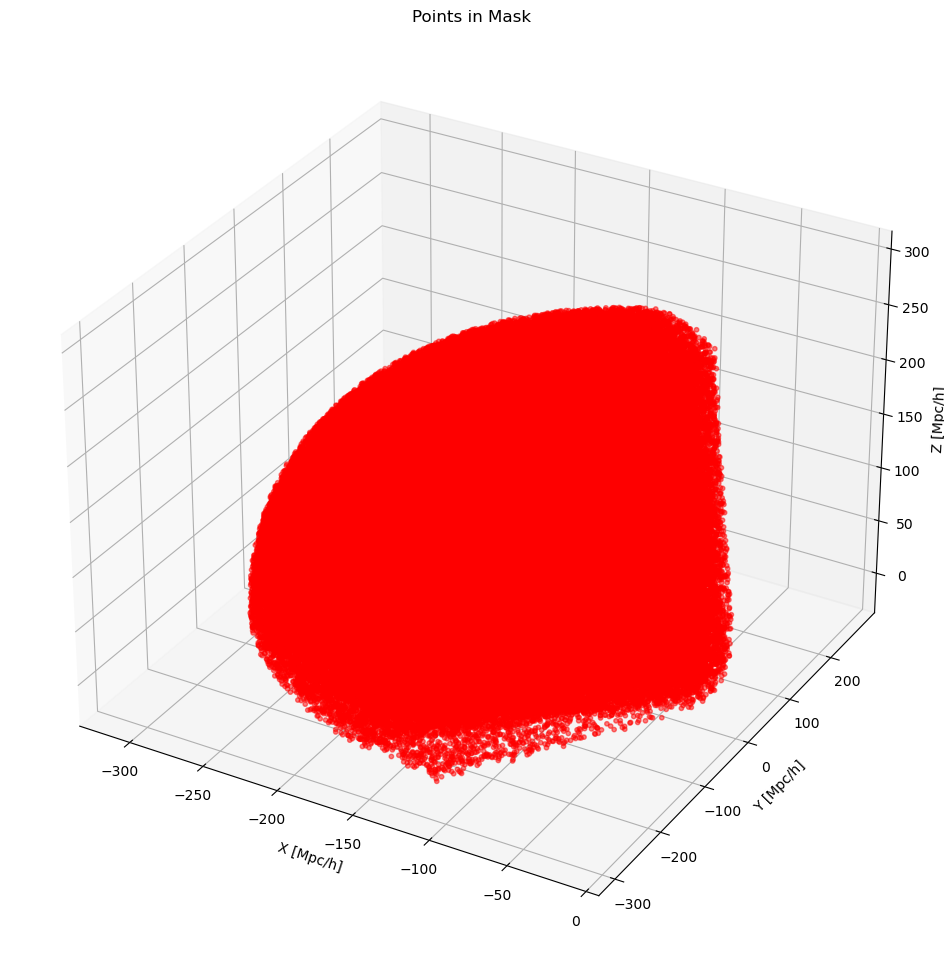

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
##
# This will take the beautiful 3D array of pts and plot along each axis
# (x, y, z)
##
ax.scatter(points_in_mask[0,::100],points_in_mask[1,::100], points_in_mask[2,::100],
           color = 'red', s=10, alpha=0.5,
          )
ax.set(xlabel='X [Mpc/h]',
       ylabel='Y [Mpc/h]',
       zlabel='Z [Mpc/h]')

plt.title("Points in Mask");

#### KDTree Data Structure: Find closest point given large number of points
- Splits by dimension in halves from middle point
- Stores points as nodes in tree
- Continous to split within halves from middle point and stores childs
- Leafs nodes when splitting can occur no more

- Traverse through tree by dimensions. Levels: X -> Y -> Z -> X...
- Moves to child with nearest coordinate
- Repeats until reaches leaf node, return min dist.
- Travel back up tree and compare with nodes to determine no other possible min dist
- Prunes children with parents > min dist
Complexity: O(d*nlog*n) & O(dn) storage, d - dimensions




In [ ]:
def kd_tree(void_cat):
    """We are creating a function to make a KDTree to find the number of points in 
    and out of a catalogue.
    
    Parameters
    ----------
    point_coords: ndarray has a shape of (3,N)
        This is the list of points to query the given void catalogue. N is the number of points given. 
    void_cat: Astropy Table
        This is the given void catalogue.
    
    Returns
    -------
    true_inside: ndarray of shape (N,1)
        Is this the boolean array of length N (same length as point_coords). True means that 1 point 
        is inside the hole.
    """
#############
    cx = void_cat['x']
    cy = void_cat['y']
    cz = void_cat['z']

    sphere_coords = np.array([cx, cy, cz])

    #The .T is meant to transpose the array from (3,1054) to (1054,3)
    sphere_tree = neighbors.KDTree(sphere_coords.T)
    print("KDTree")

##############
    
    return sphere_tree

### Points Query
 - Parameters: Points in Mask Coor, KDTree, Data Catalog
 - Will get the distance and index of that point from KDTree
 - dist: Distance of point in KDtree from hole
 - idx: Index of point
 - Compare dist to the index of that point to the actual distance in the catalog
 - if < then the point falls within the hole
 - Return query of every point inside catalog

In [ ]:
def point_query(point_coords, sphere_tree, void_cat):

    dist, idx = sphere_tree.query(point_coords.T, k = 1)

    true_inside = dist < void_cat['radius'][idx]
    
    print("Point Query")

    return true_inside

### Comparison of Void Catalogs
1. Declare False boolean arrays, size U = 21. 
    - Why? 21 is the sweet spot
2. Copy points_in_mask data matrix
3. Create KDTree of each Void Catalog
4. For loop through size of each array
    - Δ = Array size 3 with Random values. 
        - Why? In order for the KDTree to structure efficently,
          it must be randomized. Hence why we shift by 3.
    - Copy each array from points_in_mask and add Δ[i]
    - Run Point Querery Function on both data sets.
    - Gather sum of inside and sum of outside point for each
    - Logic functions
    
    
    

In [ ]:
start_time = time.time()

U = 1

count_in_V1 = np.zeros(U)
count_out_V1 = np.zeros(U)

count_in_V2 = np.zeros(U)
count_out_V2 = np.zeros(U)

inside_both = np.zeros(U)
inside_neither = np.zeros(U)
inside_V1 = np.zeros(U)
inside_V2 = np.zeros(U)

points_in_mask_copy = points_in_mask.copy()

kdTree_V1 = kd_tree(data_table_V1)
kdTree_V2 = kd_tree(data_table_V2)


for i in range(U):
    

    
    delta = np.random.rand(3)
    
    points_in_mask_copy[0] = points_in_mask[0] + delta[0]
    points_in_mask_copy[1] = points_in_mask[1] + delta[1]
    points_in_mask_copy[2] = points_in_mask[2] + delta[2]
    
#     print(points_in_mask_copy[:,:10])
    
    true_inside_V1 = point_query(points_in_mask_copy, kdTree_V1, data_table_V1)

    count_in_V1[i] = np.sum(true_inside_V1)

    # The "~" inverts the array. So we have true_inside inverted to add up the falses instead of the trues
    count_out_V1[i] = np.sum(~true_inside_V1)
    
    # print(time.time() - start_time)

    # total_KIAS = count_in_KIAS + count_out_KIAS

    true_inside_V2 = point_query(points_in_mask_copy, kdTree_V2, data_table_V2)

    count_in_V2[i] = np.sum(true_inside_V2)

    # The "~" inverts the array. So we have true_inside inverted to add up the falses instead of the trues
    count_out_V2[i] = np.sum(~true_inside_V2)

    #total_DEL = count_in_DEL + count_out_DEL
    
    # This is the number of points that are inside both A and B
    inside_V1_and_V2 = np.logical_and(true_inside_V1, true_inside_V2)
    inside_both[i] = np.sum(inside_V1_and_V2)
    
    # This is the number of points that are in neither A and B
    not_inside_V1_and_V2 = np.logical_and(~true_inside_V1, ~true_inside_V2)
    inside_neither[i] = np.sum(not_inside_V1_and_V2)
    
    # This is the number of points that are in A but not B
    inside_v1 = np.logical_and(true_inside_V1, ~true_inside_V2)
    inside_V1[i] = np.sum(inside_v1)
    
    # This is the number of points that are not in A but are in B
    inside_v2 = np.logical_and(~true_inside_V1, true_inside_V2)
    inside_V2[i] = np.sum(inside_v2)
    
print(time.time() - start_time)
print('\nNumber of points inside V1:', count_in_V1)
print('\nNumber of points outside V2:', count_out_V1)
print('\nNumber of points inside V1:', count_in_V2)
print('\nNumber of points outside V2:', count_out_V2)
print("\nThis is the total number of points: {}".format(n_points))
# print("\nThis is the total number of points in Delaunay: {}".format(total_DEL))

KDTree
KDTree
Point Query
Point Query
209.6505479812622

Number of points inside V1: [13347855.]

Number of points outside V2: [9694857.]

Number of points inside V1: [13347855.]

Number of points outside V2: [9694857.]

This is the total number of points: 23042712


23042712

In [ ]:
count_in_V1[0] = np.sum(true_inside_V1)


In [ ]:
count_in_V1

array([13347855.])

In [ ]:
count_out_V1


array([9694857.])

In [ ]:
count_out_V1

array([9694857.])

### This is the number of points that are inside both A and B

In [ ]:
inside_V1_and_V2 = np.logical_and(true_inside_V1, true_inside_V2)

np.sum(inside_V1_and_V2), count_in_V1, count_in_V2

(13347855, array([13347855.]), array([13347855.]))

### This is the number of points that are in neither A and B

In [ ]:
not_inside_V1_and_V2 = np.logical_and(~true_inside_V1, ~true_inside_V2)

np.sum(not_inside_V1_and_V2), count_in_V1, count_in_V2

(9694857, array([13347855.]), array([13347855.]))

### This is the number of points that are in A but not B

In [ ]:
inside_V1 = np.logical_and(true_inside_V1, ~true_inside_V2)

np.sum(inside_V1)

0

### This is the number of points that are not in A but are in B

In [ ]:
inside_V2 = np.logical_and(~true_inside_V1, true_inside_V2)

np.sum(inside_V2)

0

## Fraction of points: Calculate the ratios of the given sums

- in A
- in B
- in A ∧ B
- in ¬(A ∧ B)
- in A ∧¬B
- in B ∧¬A
-   |
-   |
- \ /
- The closer they are to zero, the more similar they are

In [ ]:
r_V1 = count_in_V1 / n_points
print(r_V1)

[0.5792658]


In [ ]:
r_V2 = count_in_V2 / n_points
print(r_V2)

[0.5792658]


In [ ]:
r_V1_V2 = np.sum(inside_V1_and_V2) / n_points
print(r_V1_V2)

0.5792657999631293


In [ ]:
r_not_V1_V2 = np.sum(not_inside_V1_and_V2) / n_points
print(r_not_V1_V2)

0.4207342000368707


In [ ]:
r_V1_not_V2 = np.sum(inside_V1) / n_points
print(r_V1_not_V2)

0.0


In [ ]:
r_V2_not_V1 = np.sum(inside_V2) / n_points
print(r_V2_not_V1)

0.0


In [ ]:
Sum = r_V1 + r_not_V1_V2 + r_V1_not_V2 + r_V2_not_V1
Sum

array([1.])

### x̄ & σ of Void Catalogs Ratios

### Catalog 1

In [ ]:
average_V1 = np.mean(count_in_V1)
r_average_V1 = average_V1 / n_points
std_V1 = np.std(count_in_V1)
r_std_V1 = std_V1 / n_points

print('\nRatio of V1 Points:', r_average_V1)
print('\nRatio SD:', r_std_V1)


Ratio of V1 Points: 0.5792657999631293

Ratio SD: 0.0


### Catalog 2

In [ ]:
average_V2 = np.mean(count_in_V2)
r_average_V2 = average_V2 / n_points
std_V2 = np.std(count_in_V2)
r_std_V2 = std_V2 / n_points

print('\nRatio of V2 Points:', r_average_V2)
print('\nRatio SD:', r_std_V2)


Ratio of V2 Points: 0.5792657999631293

Ratio SD: 0.0


### x̄ & σ

In [ ]:
average_inside = np.mean(inside_both)
r_average_inside = average_inside / n_points

std_both = np.std(inside_both)
r_std_both = std_both / n_points

print('\nRatio of Points Inside:', r_average_inside)
print('\nRatio SD:', r_std_both)


Ratio of Points Inside: 0.5792657999631293

Ratio SD: 0.0


In [ ]:
average_outside = np.mean(inside_neither)
r_average_outside = average_outside / n_points

std_outside = np.std(inside_neither)
r_std_outside = std_outside / n_points

print('\nRatio of Points Outside:', r_average_outside)
print('\nRatio SD:', r_std_outside)


Ratio of Points Outside: 0.4207342000368707

Ratio SD: 0.0


In [ ]:
average_in_V1 = np.mean(inside_V1)
r_average_in_V1 = average_in_V1 / n_points

std_in_V1 = np.std(inside_neither)
r_std_in_V1 = std_in_V1 / n_points


print('\Ratio of Points in V1:', r_average_in_V1)
print('\nRatio SD:', r_std_in_V1)

\Ratio of Points in V1: 0.0

Ratio SD: 0.0


In [ ]:
average_in_V2 = np.mean(inside_V2)
r_average_in_V2 = average_in_V2 / n_points

std_in_V2 = np.std(inside_neither)
r_std_in_V2 = std_in_V2 / n_points

print('\Ratio of Points in V2:', average_in_V2)
print('\nRatio SD:', r_std_in_V2)

\Ratio of Points in V2: 0.0

Ratio SD: 0.0
